 # Predicting the number of taxi orders

## Contents <a id='back'></a>

* [Intro](#intro)
* [Stage 1. Data loading](#1)
    * [1.1 Data exploration](#1.1)
* [Stage 2. Data preprocessing](#2)
    * [2.2 Graphical data exploration](#2.2)
* [Stage 3. Model training](#3)
    * [3.1 DecisionTreeRegressor](#3.1)
    * [3.2 RandomForestRegressor](#3.2)
    * [3.3 LinearRegression](#3.3)
    * [3.4 LightGBM](#3.4)
* [Conclusion](#conclusion)

## Introduction <a id='intro'></a>

We work for the taxi company 'Sweet Lift'. We collected historical data on taxi orders at airports. To attract more drivers during rush hour, we need to predict the number of taxi orders for the next hour.

## Stage 1. Data loading <a id='1'></a>

In [2]:
# General libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly as py
import plotly.graph_objects as go

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
# Load the data files into DataFrame
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

### 1.1 Data exploration <a id='1.1'></a>

In [4]:
# printing the general/summary information and first rows of df
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


The dataset contains the following fields:
- `datetime` — date and time of the reservation
- `num_orders` — number of reservations

## Stage 2. Data preprocessing <a id='2'></a>

In [5]:
# check for duplicates
df.duplicated().sum()

0

In [6]:
# changing the data type of the 'datetime' from object to datetime64 and set it as index
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0])

In [7]:
# checking if dates and times are in chronological order
df.index.is_monotonic_increasing

True

In [8]:
# verify first and last date
print(df['datetime'].min())
print(df['datetime'].max())

2018-03-01 00:00:00
2018-08-31 23:50:00


Since the prediction are required for next hour, we are going to resample the dataframe basing it on hour by hour:

In [9]:
# resampling for an hour
df_hour = df.copy()
df_hour = df_hour.set_index('datetime')
df_hour = df_hour.resample('1H').sum()

In [10]:
# descriptive statistics
df_hour.describe().round()

,num_orders
count,4416.0
mean,84.0
std,45.0
min,0.0
25%,54.0
50%,78.0
75%,107.0
max,462.0


### 2.2 Graphical data exploration <a id='2.1'></a>

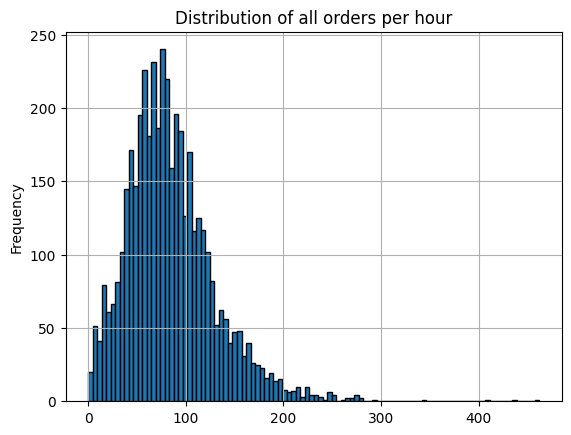

In [11]:
df_hour['num_orders'].plot(kind='hist', bins=100, edgecolor = 'black', grid=True, title='Distribution of all orders per hour')
plt.show()

So, the distribution is skewed to the right. The mean is slightly greater than the median.

In [12]:
fig = go.Figure([go.Scatter(x=df_hour.index, y=df_hour['num_orders'])])
fig.show()

Let's analyze now the trend of the average number of orders on a monthly, daily and hourly base:

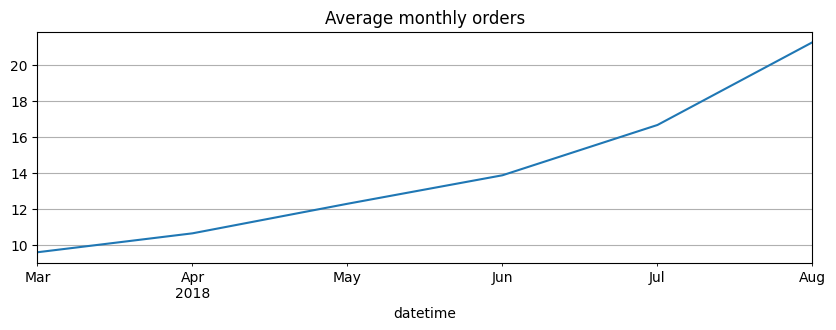

In [13]:
df.set_index('datetime')['num_orders'].resample('1M').mean().plot(grid=True,figsize=(10,3))
plt.title('Average monthly orders')
plt.show()

So, average number of orders increase from March to August. Let's go deeper:

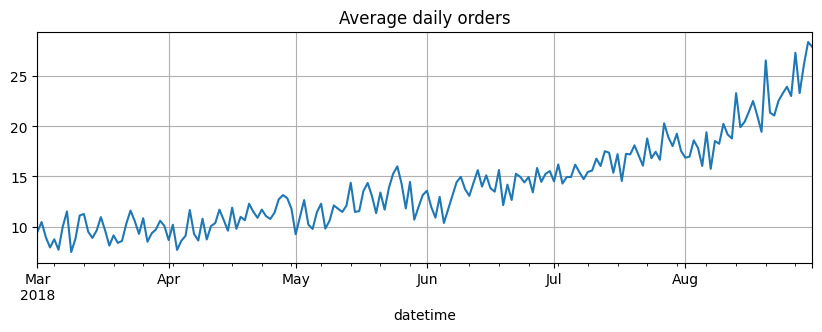

In [14]:
df.set_index('datetime')['num_orders'].resample('1D').mean().plot(grid=True,figsize=(10,3))
plt.title('Average daily orders')
plt.show()

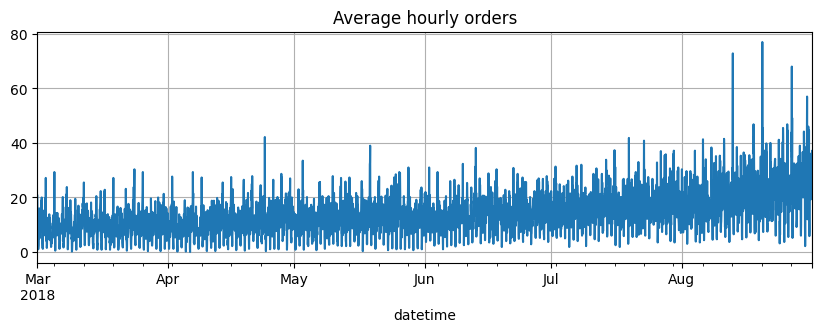

In [15]:
df.set_index('datetime')['num_orders'].resample('1H').mean().plot(grid=True,figsize=(10,3))
plt.title('Average hourly orders')
plt.show()

Of course, there is much more noise for the daily base and even more for the hourly base.

We add four new features to the table: month, day, day of the week and the hour. Column titles should be as follows: 'month', 'day', 'dayofweek', 'hour'.

In [16]:
# creating new features
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Let's take a max_lag = 3 and rolling_mean_size = 5:

In [17]:
make_features(df_hour, 3, 5)

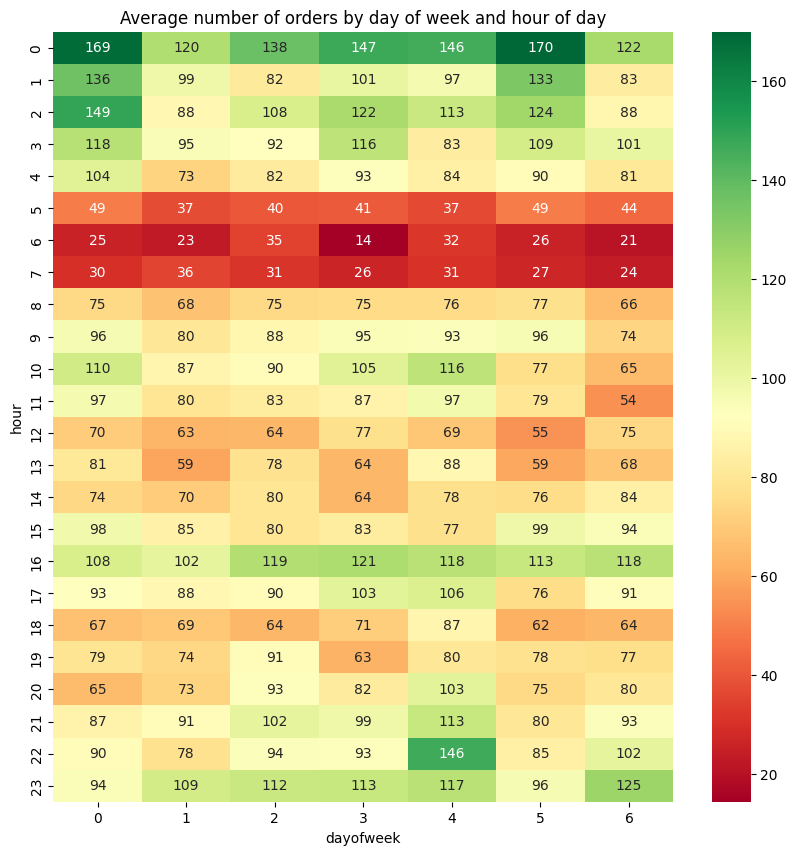

In [18]:

pivoted_df = df_hour.pivot_table(index=['hour'], columns=['dayofweek'], values=['num_orders'], aggfunc='mean')
pivoted_df = pivoted_df.droplevel(0, axis=1)
plt.figure(figsize=(10, 10))
sns.heatmap(pivoted_df, cmap="RdYlGn", fmt=".0f", annot=True)
plt.title('Average number of orders by day of week and hour of day')
plt.show()

So, generally speaking, the more intensive hours are between 11pm and 3am and between 4pm and 5pm while the less intensive hours are between 5 and 8am. 

To better understand the time series, let's look at trends and seasonality.

In [19]:
df_hour = df_hour.dropna()
decomposed = seasonal_decompose(df_hour['num_orders'])

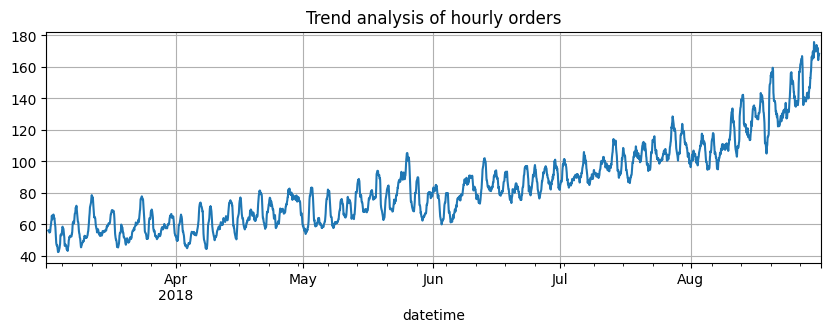

In [20]:
decomposed.trend.plot(figsize=(10,3), grid=True)
plt.title('Trend analysis of hourly orders')
plt.show()

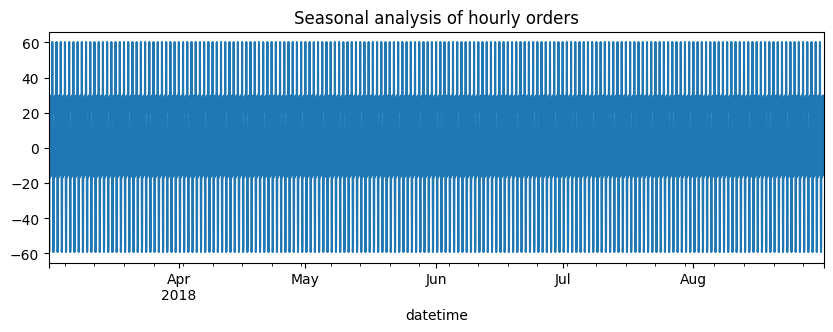

In [21]:
decomposed.seasonal.plot(figsize=(10,3))
plt.title('Seasonal analysis of hourly orders')
plt.show()

Too noisy, let's analyze only August:

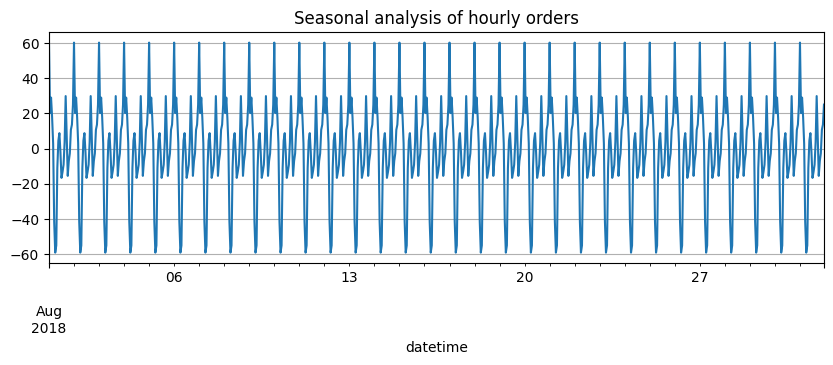

In [22]:
decomposed.seasonal['2018-08': '2018-08'].plot(figsize=(10,3), grid=True)
plt.title('Seasonal analysis of hourly orders')
plt.show()

Since it seems periodic, let's take only three random days in August:

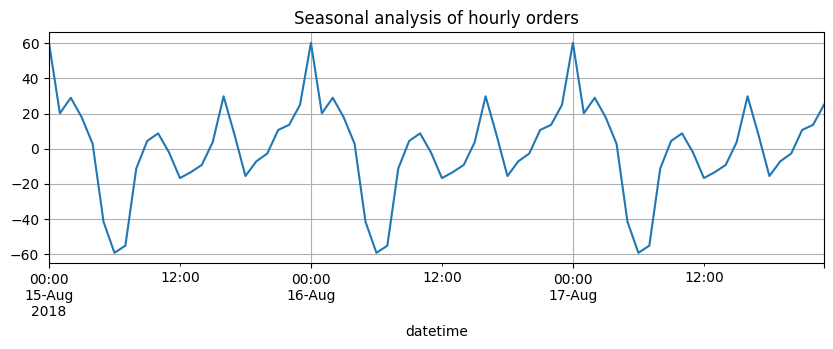

In [23]:
decomposed.seasonal['2018-08-15': '2018-08-17'].plot(figsize=(10,3), grid=True)
plt.title('Seasonal analysis of hourly orders')
plt.show()

So, as previously seen, there are peaks at midnight and off-peaks at 6am.

## Stage 3. Model training <a id='3'></a>

The aim of this part is to achieve a RMSE below 48. So, we will train different models to accomplish it.

In [24]:
train, test = train_test_split(df_hour, shuffle=False, test_size=0.1)

In [25]:
X_train = train.drop('num_orders', axis=1)
Y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
Y_test = test['num_orders']

In [26]:
# Create a dataframe named "summary_models" where we save RMSE of different models
summary_models = pd.DataFrame(columns=['RMSE'])

### 3.1 DecisionTreeRegressor <a id='3.1'></a>

In [27]:
tree_dep = []
tree_rmse = []
best_rmse = float('inf')
table_tree_rmse= pd.DataFrame(columns=['max_depth', 'RMSE'])

for depth in range(1, 20):
    
    dtr = DecisionTreeRegressor(random_state=12345, max_depth=depth).fit(X_train, Y_train)
    predicted_valid = dtr.predict(X_test)
    
    rmse = mean_squared_error(Y_test, predicted_valid, squared=False) 
    tree_dep.append(depth)
    tree_rmse.append(rmse)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_depth = depth
    
    new_row = {'max_depth': depth, 'RMSE': f'{rmse:.2f}'}
    table_tree_rmse = pd.concat([table_tree_rmse,pd.DataFrame([new_row])], ignore_index=True)

# Save info
summary_models.loc['DecisionTreeRegressor'] = {'RMSE': best_rmse}

print('Best RMSE =', f'{best_rmse:.2f}' ' | max_depth =', f'{best_depth:.0f}')
table_tree_rmse

Best RMSE = 51.69 | max_depth = 13


,max_depth,RMSE
0,1,74.07
1,2,72.74
2,3,63.12
3,4,59.98
4,5,56.76
5,6,58.07
6,7,58.36
7,8,56.45
8,9,54.49
9,10,54.27


### 3.2 RandomForestRegressor <a id='3.2'></a>

In [28]:

forest_tree_num = []
forest_tree_dep = []
forest_rmse = []
best_rmse = float('inf')
table_forest_rmse= pd.DataFrame(columns=['n_estim', 'max_depth', 'RMSE'])

for est in range(8, 22, 4):
        for depth in range(4, 17, 4):
                
                rfr = RandomForestRegressor(random_state = 12345, n_estimators= est, max_depth=depth).fit(X_train, Y_train)

                predicted_valid = rfr.predict(X_test)
                
                rmse = mean_squared_error(Y_test, predicted_valid, squared=False) 
                
                forest_tree_num.append(est)
                forest_tree_dep.append(depth)
                forest_rmse.append(rmse)
                
                if rmse < best_rmse:
                        best_rmse = rmse
                        best_depth = depth
                        best_est = est
                
                new_row = {'n_estim': est, 'max_depth': depth, 'RMSE': f'{rmse:.2f}'}
                table_forest_rmse = pd.concat([table_forest_rmse,pd.DataFrame([new_row])], ignore_index=True)

# Save info
summary_models.loc['RandomForestRegressor'] = {'RMSE': best_rmse}

print('Best RMSE =', f'{best_rmse:.2f}' ' | max_depth =', f'{best_depth:.0f}' ' | estim =', f'{best_est:.0f}')
table_forest_rmse

Best RMSE = 48.20 | max_depth = 12 | estim = 8


,n_estim,max_depth,RMSE
0,8,4,58.21
1,8,8,52.96
2,8,12,48.20
3,8,16,48.78
4,12,4,57.42
5,12,8,51.85
6,12,12,48.65
7,12,16,48.43
8,16,4,57.27
9,16,8,51.23


### 3.3 LinearRegression <a id='3.3'></a>

In [29]:
lr = LinearRegression().fit(X_train, Y_train)

predicted_valid = lr.predict(X_test)

rmse = mean_squared_error(Y_test, predicted_valid, squared=False)

# Save info
summary_models.loc['LinearRegression'] = {'RMSE': rmse}

print('LinearRegression: RMSE =', f'{rmse:.2f}')

LinearRegression: RMSE = 52.73


So, none of these models have a RMSE under 48. We will use a gradient boosting technique: the LGBMRegressor

### 3.4 LightGBM <a id='3.4'></a>

First, we look for the best parameters to use in the prediction model:

In [30]:
param_grid = {'max_depth':[4, 6, 8],
                'n_estimators':[10, 100, 200],
                'learning_rate':[0.01, 0.1],
                'reg_alpha':[1, 2, 3]}

lgbm_cv = GridSearchCV(LGBMRegressor(), param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error')

lgbm_cv.fit(X_train, Y_train)

best_parameters = lgbm_cv.best_params_
print('LGBMRegressor best parameters:', best_parameters)

LGBMRegressor best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 1}


So we now use the parameters just found to develop our best LGBMRegressor model:

In [31]:
best_lgbm = LGBMRegressor(learning_rate = 0.1,
                        max_depth = 4,
                        n_estimators = 200,                        
                        reg_alpha = 1)

best_lgbm.fit(X_train, Y_train)

pred = best_lgbm.predict(X_test)

rmse = mean_squared_error(Y_test, pred, squared=False)

# Save info
summary_models.loc['LGBMRegressor'] = {'RMSE': rmse}

print('Best LightGBM RMSE =', f'{rmse:.2f}')

Best LightGBM RMSE = 42.91


Ok, we have accomplished it. Our model has a RMSE below 48

In [32]:
summary_models.round(2)

,RMSE
DecisionTreeRegressor,51.69
RandomForestRegressor,48.20
LinearRegression,52.73
LGBMRegressor,42.91


## Conclusion <a id='conclusion'></a>

We started our project with the aim of building a model able to predict the number of taxi orders for the next hour. To do so, we have historical data of taxi order.

First, we explored the data, preprocessed it and have it represented graphically. We realized that there are, on average, peak hours and off-peak hours. To do that we added some time-series related features: month, day, dayofweek, hour.

After that we decomposed the 'hour-based' dataframe to discover the trend and seasonality of the number of orders ('num_orders').

Finally we trained several models with the aim of getting one with a RMSE < 48.  LGBMRegressor was the one.